In [9]:
import os
from urllib.request import urlretrieve

import itk
import scipy.signal
import numpy as np
import matplotlib.pyplot as plt

# itk-ultrasound must be built/installed
assert 'BModeImageFilter' in dir(itk)

In [4]:
RF_INPUT_FILE = 'Input/PhantomRFFrame0.mha'
if not os.path.exists(RF_INPUT_FILE):
    url = 'https://data.kitware.com/api/v1/file/6111a4392fa25629b9288366/download'
    urlretrieve(url, RF_INPUT_FILE)

In [10]:
rf_image = itk.imread(RF_INPUT_FILE)
image = itk.b_mode_image_filter(rf_image)

Template itk::ImageToImageFilter<itk::Image<itk::Vector<float,2>,2>,itk::Image<itk::CovariantVector<float,2>,2>>
 already defined as <class 'itk.itkImageToImageFilterAPython.itkImageToImageFilterIVF22ICVF22'>
 is redefined as {cl}
Template itk::ImageToImageFilter<itk::Image<itk::Vector<float,3>,3>,itk::Image<itk::CovariantVector<float,3>,3>>
 already defined as <class 'itk.itkImageToImageFilterAPython.itkImageToImageFilterIVF33ICVF33'>
 is redefined as {cl}


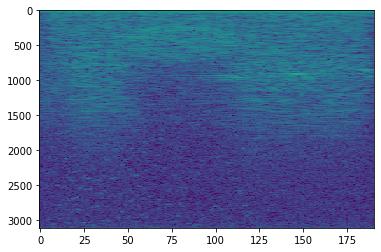

In [11]:
imgargs = {'interpolation':'none','aspect':'auto'}
plt.imshow(np.transpose(image),**imgargs)

In [12]:
c_tang = 0.5

In [13]:
# Compute projection matrix at each pixel
def compute_P(smoothed_image:np.array) -> np.array:
    g_x, g_y = np.gradient(smoothed_image)

    grad_mag = np.power(np.power(g_x,2) + np.power(g_y,2),0.5)
    g_x_norm = np.divide(g_x, grad_mag)
    g_y_norm = np.divide(g_y, grad_mag)
    
    P = np.zeros([smoothed_image.shape[0],smoothed_image.shape[1],2,2])
    
    P[:,:,0,0] = 1 - g_x_norm * g_x_norm
    P[:,:,1,0] = 0 - g_y_norm * g_x_norm
    P[:,:,0,1] = 0 - g_x_norm * g_y_norm
    P[:,:,1,1] = 1 - g_y_norm * g_y_norm
    return P

In [14]:
# Compute Hessian matrix at each pixel
def compute_H(smoothed_image:itk.Image) -> np.array:
    hessian_image = itk.hessian_recursive_gaussian_image_filter(smoothed_image)

    hessian_matrix = np.zeros([smoothed_image.shape[0],smoothed_image.shape[1],2,2])
    
    for i in range(smoothed_image.shape[0]):
        for j in range(smoothed_image.shape[1]):
            hessian_matrix[i,j,0,0] = hessian_image.GetPixel([j,i]).GetNthComponent(0)
            hessian_matrix[i,j,0,1] = hessian_image.GetPixel([j,i]).GetNthComponent(1)
            hessian_matrix[i,j,1,0] = hessian_image.GetPixel([j,i]).GetNthComponent(1)
            hessian_matrix[i,j,1,1] = hessian_image.GetPixel([j,i]).GetNthComponent(2)
    return hessian_matrix

In [21]:
# Compute curvature directions v1 and v2 at each pixel
# as the eigenvectors of the matrix PHP
def get_curvature_directions(smoothed_image:itk.Image, P:np.array,H:np.array, index:list) -> np.array:
    assert(P.ndim == 4 and P.shape[2] == 2 and P.shape[3] == 2)
    assert(H.ndim == 4 and H.shape[2] == 2 and H.shape[3] == 2)
    
    arr = itk.FixedArray[itk.D,2]()
    mat = itk.Matrix[itk.D,2,2]()

    H_index = H[index[1],index[0],:,:]
    P_index = P[index[1],index[0],:,:]
    
    PHP = np.matmul(np.matmul(P_index, H_index), P_index)
    eigenvals, eigenvecs = np.linalg.eig(PHP)

    if(eigenvals[0] > eigenvals[1]):
        v1 = eigenvecs[0]
        v2 = eigenvecs[1]
    else:
        v1 = eigenvecs[1]
        v2 = eigenvecs[0]
    
    basis = np.transpose(np.array([v1, v2])) # column-order basis [v1 v2]
    
    return basis

In [16]:
# Compute the diffusion coefficient 1-k == c(q(i,j;t)) at each pixel
def compute_diffusion_coefficients(arr):
    delta_t = 0.05
    eps = 1e-11
    rho = 0.2
    q0 = 1 # Speckle coefficient of variation (fully developed speckle)
    
    # Compute speckle scale function
    qt = q0 * np.exp(-1 * (1 * delta_t) * rho)
    
    # Compute gradients and laplacian at each pixel
    (Ix, Iy) = np.gradient(arr)
    di = np.sqrt(np.power(Ix, 2) + np.power(Iy, 2))
    di2 = scipy.ndimage.filters.laplace(arr)

    # Compute instantaneous coefficient of variation
    T1 = 0.5 * np.power(np.divide(di, arr + eps), 2)
    T2 = 0.0625 * np.power(np.divide(di2, arr + eps), 2)
    T3 = np.power(1 + 0.25 * np.divide(di2, arr + eps), 2)
    T = np.sqrt(np.divide(T1 - T2, T3 + eps).astype('complex'))

    # Compute diffusion coefficient c(q(x,y;t))
    dd = np.divide(np.power(T, 2) - qt ** 2, (qt ** 2) * (1 + qt ** 2) + eps)
    cq = np.divide(1, 1 + dd)
    
    return cq

In [17]:
def change_of_basis(basis, diffusion) -> np.array:
    return np.matmul(basis,diffusion)

In [18]:
def osrad_filter(image:itk.Image,
                 delta_t:float=0.05,
                 c_tang:float=0.5,
                 n_iterations=50) -> itk.Image:
    
    res = np.zeros([*image.shape,2])
    
    for n in range(1,n_iterations+1):
        # Get the diffusion coefficient 1-k (aka c(q(x,y;t)) at each pixel
        cq = np.real(compute_diffusion_coefficients(itk.array_view_from_image(image)))
        # Get the gradient at each pixel
        Ix, Iy = np.gradient(image)
        grad = np.concatenate([np.expand_dims(Ix,2),np.expand_dims(Iy,2)],axis=2)
        # Get the smoothed image u*
        g_image = itk.smoothing_recursive_gaussian_image_filter(image,sigma=0.5)
        
        P_arr = compute_P(g_image)
        H_arr = compute_H(g_image)

        # Iterate over the image
        for i in range(image.shape[0]):
            for j in range(image.shape[1]):
                # Form a basis from the gradient and the principal curvature direction
                basis = get_curvature_directions(g_image,P_arr,H_arr,index=[j,i])
                basis[:,1] = basis[:,0]
                basis[0,0] = Ix[i,j]
                basis[1,0] = Iy[i,j]

                # Compose the diffusion tensor D in the curvature basis [v1, v2]
                D = np.array([[cq[i,j],0],[0,c_tang]])

                # Perform a change of basis to get the diffusion tensor in image coordinates
                D_coord = change_of_basis(basis,D)

                # Compute c*grad(I[x,y])
                res[i,j,:] = np.matmul(D,grad[i,j,:])

        # Compute divergence
        Ixx, Iyx = np.gradient(res[:,:,0])
        Ixy, Iyy = np.gradient(res[:,:,1])
        diff = Ixx + Iyy
        
        # Image update step with time constant
        arr = image + delta_t * diff
        
        # Convert from numpy -> itk for next iteration
        image2 = itk.image_from_array(arr.astype(np.float32))
        image2.CopyInformation(image)
        image = image2
        
        # Sanity check to verify values are changing
        print(f'{n}: Image[0,0]: {image.GetPixel([0,0])}')
        
    return image

In [28]:
img2 = osrad_filter(image, delta_t=0.1, n_iterations=50)

1: Image[0,0]: 0.9008183479309082
2: Image[0,0]: 0.8965126276016235
3: Image[0,0]: 0.8921123147010803
4: Image[0,0]: 0.8876242637634277
5: Image[0,0]: 0.8830538988113403
6: Image[0,0]: 0.8784056305885315
7: Image[0,0]: 0.8736830949783325
8: Image[0,0]: 0.8688892722129822
9: Image[0,0]: 0.864026665687561
10: Image[0,0]: 0.859097421169281
11: Image[0,0]: 0.8541032671928406
12: Image[0,0]: 0.8490457534790039
13: Image[0,0]: 0.8439262509346008
14: Image[0,0]: 0.8387459516525269
15: Image[0,0]: 0.8335059285163879
16: Image[0,0]: 0.8282071948051453
17: Image[0,0]: 0.8228507041931152
18: Image[0,0]: 0.8174373507499695
19: Image[0,0]: 0.8119680285453796
20: Image[0,0]: 0.8064435720443726
21: Image[0,0]: 0.8008649349212646
22: Image[0,0]: 0.7952329516410828
23: Image[0,0]: 0.7895485758781433
24: Image[0,0]: 0.7838127017021179
25: Image[0,0]: 0.7780263423919678
26: Image[0,0]: 0.7721905708312988
27: Image[0,0]: 0.7663064002990723
28: Image[0,0]: 0.7603749632835388
29: Image[0,0]: 0.7543973922729

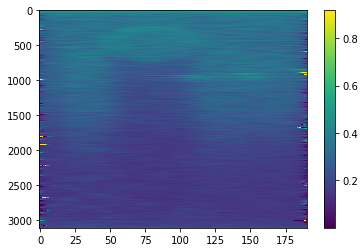

In [34]:
# View smoothing results
plt.imshow(np.transpose(np.clip(img2,np.min(image),np.max(image))),**imgargs)
plt.colorbar()
plt.show()

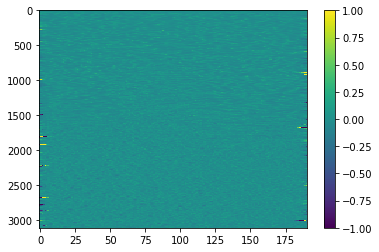

In [42]:
# Show difference from original image, clipped within reasonable range
plt.imshow(np.transpose(np.clip(img2 - itk.array_from_image(image),-1,1)),**imgargs)
plt.colorbar()
plt.show()

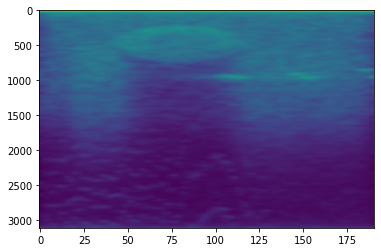

In [31]:
# Compare with Gaussian smoothed image
plt.imshow(np.transpose(itk.smoothing_recursive_gaussian_image_filter(image,sigma=0.3)),**imgargs)

## Development

Get the Gaussian smoothed image.

In [26]:
g_image = itk.smoothing_recursive_gaussian_image_filter(image,sigma=0.5)

Get the derivative at each point.

In [27]:
np.identity(2)

array([[1., 0.],
       [0., 1.]])

In [28]:
g_x, g_y = np.gradient(g_image)

grad_mag = np.power(np.power(g_x,2) + np.power(g_y,2),0.5)
g_x_norm = np.divide(g_x, grad_mag)
g_y_norm = np.divide(g_y, grad_mag)

grad_normalized = np.transpose(np.array([[g_x_norm[0,0], g_y_norm[0,0]]]))
#print(grad_normalized)
P = np.identity(2) - np.matmul(grad_normalized, np.transpose(grad_normalized))
print(P)

[[ 0.90477878 -0.29352024]
 [-0.29352024  0.09522128]]


Get the Hessian at each point to give insight into curvature.

In [29]:
hessian_image = itk.hessian_recursive_gaussian_image_filter(g_image)

hessian_matrix = np.zeros([2,2])
hessian_matrix[0,0] = hessian_image.GetPixel(0).GetNthComponent(0)
hessian_matrix[0,1] = hessian_image.GetPixel(0).GetNthComponent(1)
hessian_matrix[1,0] = hessian_image.GetPixel(0).GetNthComponent(1)
hessian_matrix[1,1] = hessian_image.GetPixel(0).GetNthComponent(2)
print(hessian_matrix)

[[-0.30491626  0.0247211 ]
 [ 0.0247211   0.00146227]]


Compute the matrix PHP

In [30]:
PHP = np.matmul(np.matmul(P, hessian_matrix), P)
print(PHP)

[[-0.26261639  0.08519566]
 [ 0.08519566 -0.02763842]]


Get principal curvature directions as eigenvectors

In [31]:
eigenvals, eigenvecs = np.linalg.eig(PHP)

if(eigenvals[0] > eigenvals[1]):
    max_curvature = eigenvecs[0]
    min_curvature = eigenvecs[1]
else:
    max_curvature = eigenvecs[1]
    min_curvature = eigenvecs[0]
    
print(f'Max curvature: {max_curvature}')
print(f'Min curvature: {min_curvature}')

Max curvature: [ 0.30857935 -0.9511986 ]
Min curvature: [-0.9511986  -0.30857935]


Get eigenvectors as a basis in the curvature directions at each point.

In [32]:
arr = itk.FixedArray[itk.D,2]()
mat = itk.Matrix[itk.D,2,2]()
hessian_image.GetPixel([0,0]).ComputeEigenAnalysis(arr,mat)

print(arr)

itkFixedArrayD2 ([-0.306898, 0.00344414])


In [54]:
g_image = itk.smoothing_recursive_gaussian_image_filter(image,sigma=0.5)

P = compute_P(g_image)
H = compute_H(g_image)

basis = get_curvature_directions(image,P,H,[0,0])
print(basis)

[[ 0.30857935 -0.9511986 ]
 [-0.9511986  -0.30857935]]


In [55]:


print(np.gradient(g_image)[0][0,0])


print(np.gradient(g_image)[1][0,0])

-0.014387369
-0.044349194


Get diffusion coefficient at each point as a function of time, intensity, intensity gradient, intensity curvature

### TODO
In [29], we use a particular
flux that is decomposed in the basis of the gradient (v0)
and the maximal (v1) and minimal (v2) curvature directions
computed on the smoothed image u
∗
, where the smoothing is
obtained by convolution with a Gaussian of standard deviation
σ. The principal curvature directions are computed as two
eigenvectors of the matrix PHσP where Hσ is the Hessian
matrix of the image u
∗
and P is the projection matrix
orthogonal to the gradient direction, that is H0 = P HσP with
P = I −
³
∇u
∗
|∇u∗|
´
.
³
∇u
∗
|∇u∗|
´t
, where I is the identity matrix
in 3D. The eigenvalues of the diffusion matrix are chosen as
functions of the first order derivative of the intensity in the
corresponding eigenvector direction, and can be written in the
form λi(uvi
) = uvi
.ϕi(uvi
). The diffusion in the gradient
direction, ϕ0(x), is chosen as Perona and Malik’s diffusion
function, i.e ϕ0(x) = e
− x
2
δ2 where δ is a threshold on the
intensity derivative in the smoothed gradient direction, and
0 < ϕ1 ≤ ϕ2 <= 1 weight the diffusion in the principal
curvature directions

In [57]:
cq = np.real(compute_diffusion_coefficients(itk.array_view_from_image(image)))

Compose diffusion matrix in basis of principal curvature directions [v1, v2]

In [58]:
D = np.array([[cq[0,0],0],[0,c_tang]]) # in basis [v1, v2]
print(f'Diffusion matrix is \n{D}\n in basis \n{basis}')

Diffusion matrix is 
[[2.0161662 0.       ]
 [0.        0.5      ]]
 in basis 
[[ 0.30857935 -0.9511986 ]
 [-0.9511986  -0.30857935]]


Compute diffusion matrix in image coordinate system basis

In [60]:
D_coord = change_of_basis(basis,D)
print(D_coord)

[[ 0.62214726 -0.4755993 ]
 [-1.91777447 -0.15428968]]


Compute div(D * grad(I))

In [61]:
np.matmul(basis,D)

array([[ 0.62214726, -0.4755993 ],
       [-1.91777447, -0.15428968]])

In [62]:
D_coord

array([[ 0.62214726, -0.4755993 ],
       [-1.91777447, -0.15428968]])

In [63]:
Ix, Iy = np.gradient(image)
grad = np.concatenate([np.expand_dims(Ix,2),np.expand_dims(Iy,2)],axis=2)

In [64]:
res = np.zeros(grad.shape[:2])
res.shape

(191, 3116)

In [65]:
res = np.zeros(grad.shape)
for i in range(grad.shape[0]):
    for j in range(grad.shape[1]):
        res[i,j,:] = np.matmul(D,grad[i,j,:])

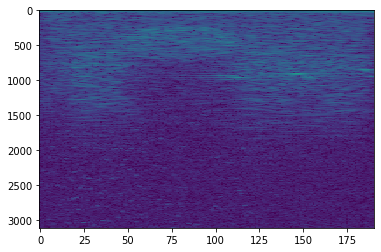

In [66]:
Ixx, Iyx = np.gradient(res[:,:,0])
Ixy, Iyy = np.gradient(res[:,:,1])

diff = Ixx + Iyy
i2 = image + 0.05 * diff
plt.imshow(np.transpose(i2),**imgargs)

In [83]:
print(np.min(img3))
print(np.max(img3))

-671.81396
7271.4873


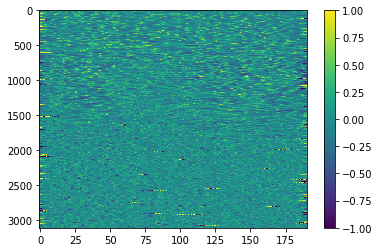

In [93]:
plt.imshow(np.transpose(np.clip(img4 - itk.array_from_image(image),-1,1)),**imgargs)
plt.colorbar()

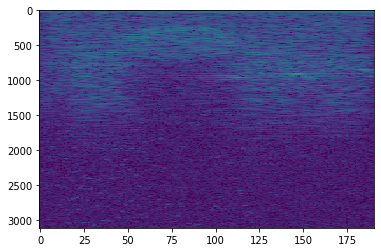

In [86]:
plt.imshow(np.transpose(image),**imgargs)

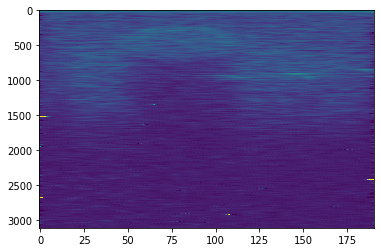

In [87]:
plt.imshow(np.transpose(np.clip(img2,np.min(image),np.max(image))),**imgargs)

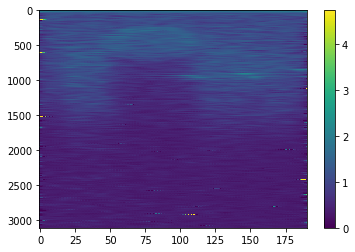

In [92]:
plt.imshow(np.transpose(np.clip(img3,np.min(image),np.max(image))),**imgargs)
plt.colorbar()
plt.show()

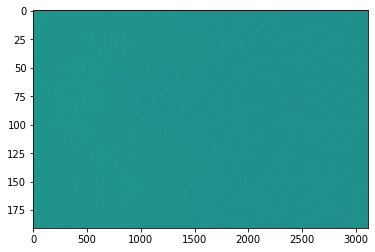

In [23]:
plt.imshow(img2,**imgargs)

In [ ]:

# Speckle-reducing Anisotropic Diffusion filter for BMode denoising
def srad_filter(image:np.ndarray,
                n_iterations:int=1,
                delta_t=0.05,
                verbose=False) -> np.ndarray:
    assert len(image.shape) == 2
    image = image.astype(np.double)
    
    eps = 1e-11
    rho = 0.2
    q0 = 1 # Speckle coefficient of variation (fully developed speckle)
    
    for n in range(1,n_iterations+1):
        # Compute speckle scale function
        qt = q0 * np.exp(-1 * (n * delta_t) * rho)
        if(verbose):
            print(f'{n}: q_0(t) = {qt}')

        # Compute gradients and laplacian at each pixel
        (Ix, Iy) = np.gradient(image)
        di = np.sqrt(np.power(Ix, 2) + np.power(Iy, 2))
        di2 = scipy.ndimage.filters.laplace(image)
        
        # Compute instantaneous coefficient of variation
        T1 = 0.5 * np.power(np.divide(di, image + eps), 2)
        T2 = 0.0625 * np.power(np.divide(di2, image + eps), 2)
        T3 = np.power(1 + 0.25 * np.divide(di2, image + eps), 2)
        T = np.sqrt(np.divide(T1 - T2, T3 + eps).astype('complex'))
        
        # Compute diffusion coefficient c(q(x,y;t))
        dd = np.divide(np.power(T, 2) - qt ** 2, (qt ** 2) * (1 + qt ** 2) + eps)
        cq = np.divide(1, 1 + dd)
        
        # Compute pixel deltas
        (D1, D2) = np.gradient(np.multiply(cq, Ix))
        (D3, D4) = np.gradient(np.multiply(cq, Iy))
        D = D1+D4

        # Update image
        image = np.real(image + np.multiply(delta_t, D))
    
    return image